In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgbm

In [2]:
# importing dataset from google drive
housing_data = pd.read_csv('/content/drive/MyDrive/ML datasets/housing.csv')

In [3]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [4]:
housing_data.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


There exist several rows with missing values. need to remove these rows from the dataset.

In [5]:
# removing the rows with missing values
housing_data = housing_data.dropna()

#### See "CF housing EDA" notebook for detailed exploratory data analysis.

In [6]:
# defining target and feature variables

x = housing_data.drop(['median_house_value', 'longitude', 'latitude'], axis = 1)
y = housing_data['median_house_value']

# identifying numerical and categorical features

num_features = list(x.drop(['ocean_proximity'], axis = 1))
cat_features = ['ocean_proximity']

# skewed and non skewed distributed features for log1p transformation

skewed_features = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
nonskewed_features = ['housing_median_age']

In [7]:
# training and testing set spliting

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 524)

### Linear Regression

In [8]:
# preprocessor

preprocessor = ColumnTransformer(
    transformers = [
        # log transfomration and scaling for numerical skewed features
        ('log_scaled', Pipeline([
            ('log', FunctionTransformer(np.log1p, validate = False)),
            ('scaler', StandardScaler())]), skewed_features),

        # scaling for non skewed numerical features
        ('scaler', StandardScaler(), nonskewed_features),

        # one hot encoder for ategorical features
        ('encoder', OneHotEncoder(drop = 'first'), cat_features)
    ])

In [9]:
# pipeline for model

lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [10]:
# model fitting and predicting

lr_pipeline.fit(x_train, y_train)
lr_y_pred = lr_pipeline.predict(x_test)

In [11]:
# model evaluation

lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_y_pred)

print("MSE:", lr_mse)
print("RMSE:", lr_rmse)
print("R²:", lr_r2)

MSE: 4944482302.178382
RMSE: 70317.01289288662
R²: 0.6362815382153564


Approximately 63.6% of the variance in median house value is explained by the model and the average prediction error is about $70,317 in median house value.

### Random Forest

In [12]:
# preprocessing
preprocessor = ColumnTransformer(
    transformers = [
        ('one_hot', OneHotEncoder(drop = 'first'), cat_features)],
    remainder = 'passthrough'
)

In [13]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state = 524))
])

In [14]:
# hyperparameter tuning
params_list = {
    'model__n_estimators': [100, 200, 300, 500, 800, 1200],
    'model__max_depth': [10, 20, 30, 40, 50, None],
    'model__min_samples_split': [2, 5, 10, 15],
    'model__min_samples_leaf': [1, 2, 4, 6],
    'model__max_features': ['sqrt', 'log2'],
    'model__bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator = rf_pipeline,
    param_distributions = params_list,
    n_iter = 20,
    scoring = 'neg_mean_squared_error',
    cv = 3,
    verbose = 2,
    random_state = 524,
    n_jobs = -1
)

In [15]:
# fiting the model
random_search.fit(x_train, y_train)

# predicting with the best parameters
best_rf = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

rf_y_pred = best_rf.predict(x_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'model__n_estimators': 800, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 20, 'model__bootstrap': True}


In [17]:
# model evaluation

rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = rf_mse ** 0.5
rf_r2 = r2_score(y_test, rf_y_pred)

print("MSE:", rf_mse)
print("RMSE:", rf_rmse)
print("R²:", rf_r2)

MSE: 3657546235.730592
RMSE: 60477.65071272686
R²: 0.7309491652584035


The model’s predictions deviate from the actual median house value by about $60k on average and the model explains roughly 73% of the variance in median house values, an improvement over Linear Regression.

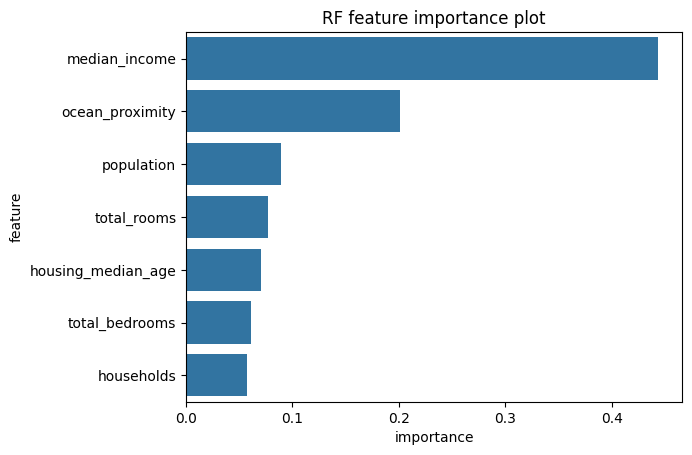

In [18]:
# feature importance plot

rf_model = best_rf.named_steps['model']                 # extracting the best random forest model from pipeline
preprocessor = best_rf.named_steps['preprocessor']      # extracting the preprocessor from pipeline

importances = rf_model.feature_importances_             # extracting feature importances
feature_names = preprocessor.get_feature_names_out()    # extracting the feature names

# creating the dataframe
feature_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_imp_df['feature'] = feature_imp_df['feature'].str.replace('onehot__', '', regex = False)
feature_imp_df['feature'] = feature_imp_df['feature'].str.replace('remainder__', '', regex = False)
feature_imp_df['base_feature'] = feature_imp_df['feature']

# Replace all one-hot columns for ocean_proximity with the original feature name
feature_imp_df.loc[feature_imp_df['feature'].str.contains('ocean_proximity'), 'base_feature'] = 'ocean_proximity'

# aggregated dataframe
agg_imp_df = feature_imp_df.groupby('base_feature', as_index = False)['importance'].sum().sort_values(by = 'importance', ascending = False)

# plot
sns.barplot(x = 'importance', y = 'base_feature', data = agg_imp_df)
plt.title('RF feature importance plot')
plt.xlabel('importance')
plt.ylabel('feature')
plt.show()

The Random Forest model relies most heavily on median_income and ocean_proximity. Other structural features (rooms, bedrooms, age) contribute less but still influence the prediction.

### XGBoost


In [19]:
# preprocessing
preprocessor = ColumnTransformer(
    transformers = [
        ('one_hot', OneHotEncoder(drop = 'first'), cat_features)],
    remainder = 'passthrough'
)

In [20]:
# pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state = 42))
])

In [21]:
# hyperparameter tuning

param_list = {
    'model__n_estimators': [300, 500, 800, 1200],
    'model__learning_rate': [0.01, 0.03, 0.05, 0.1],
    'model__max_depth': [3, 4, 5, 6, 8],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__min_child_weight': [1, 3, 5],
    'model__gamma': [0, 0.1, 0.3]
}

random_search = RandomizedSearchCV(
    estimator = xgb_pipeline,
    param_distributions = param_list,
    n_iter = 20,
    scoring='neg_mean_squared_error',
    cv = 3,
    verbose = 1,
    n_jobs = -1,
    random_state = 42
)

In [22]:
# fiting the model
random_search.fit(x_train, y_train)

# predicting with the best parameters
best_xgb = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

xgb_y_pred = best_xgb.predict(x_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'model__subsample': 0.6, 'model__n_estimators': 500, 'model__min_child_weight': 1, 'model__max_depth': 6, 'model__learning_rate': 0.03, 'model__gamma': 0.1, 'model__colsample_bytree': 0.8}


In [23]:
# model evaluation
xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_y_pred)

print("MSE:", xgb_mse)
print("RMSE:", xgb_rmse)
print("R²:", xgb_r2)

MSE: 3551439532.054118
RMSE: 59593.95549931317
R²: 0.7387544246743878


XGBoost performs better than Linear Regression and gives a very small improvement over Random Forest.

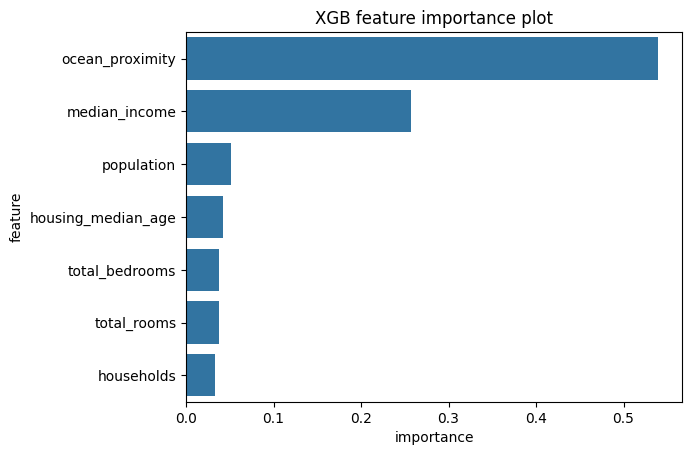

In [25]:
# feature importance plot

xgb_model = best_xgb.named_steps['model']                 # extracting the best random forest model from pipeline
preprocessor = best_xgb.named_steps['preprocessor']      # extracting the preprocessor from pipeline

importances = xgb_model.feature_importances_             # extracting feature importances
feature_names = preprocessor.get_feature_names_out()    # extracting the feature names

# creating the dataframe
feature_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_imp_df['feature'] = feature_imp_df['feature'].str.replace('onehot__', '', regex = False)
feature_imp_df['feature'] = feature_imp_df['feature'].str.replace('remainder__', '', regex = False)
feature_imp_df['base_feature'] = feature_imp_df['feature']

# Replace all one-hot columns for ocean_proximity with the original feature name
feature_imp_df.loc[feature_imp_df['feature'].str.contains('ocean_proximity'), 'base_feature'] = 'ocean_proximity'

# aggregated dataframe
agg_imp_df = feature_imp_df.groupby('base_feature', as_index = False)['importance'].sum().sort_values(by = 'importance', ascending = False)

# plot
sns.barplot(x = 'importance', y = 'base_feature', data = agg_imp_df)
plt.title('XGB feature importance plot')
plt.xlabel('importance')
plt.ylabel('feature')
plt.show()

The XGBoost model also relies most heavily on median_income and ocean_proximity and other structural features contribute less.

### LightGBM

In [26]:
# preprocessing
preprocessor = ColumnTransformer(
    transformers = [
        ('one_hot', OneHotEncoder(drop = 'first'), cat_features)],
    remainder = 'passthrough'
)

In [27]:
# pipeline
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgbm.LGBMRegressor(random_state = 42))
])

In [28]:
# hyperparameter tuning

param_list = {
    'model__n_estimators': [500, 800, 1000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [5, 7, 10, -1],
    'model__num_leaves': [31, 50, 100],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator = lgbm_pipeline,
    param_distributions=param_list,
    n_iter = 20,
    cv = 3,
    scoring = 'neg_mean_squared_error',
    verbose = 1,
    n_jobs = -1,
    random_state = 42
)

In [29]:
# fiting the model
random_search.fit(x_train, y_train)

# predicting with the best parameters
best_lgbm = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

lgbm_y_pred = best_lgbm.predict(x_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1334
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 9
[LightGBM] [Info] Start training from score 206713.682491
Best Parameters: {'model__subsample': 0.6, 'model__num_leaves': 31, 'model__n_estimators': 1000, 'model__max_depth': 10, 'model__learning_rate': 0.01, 'model__colsample_bytree': 1.0}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [30]:
# model evaluation

lgbm_mse = mean_squared_error(y_test, lgbm_y_pred)
lgbm_rmse = np.sqrt(lgbm_mse)
lgbm_r2 = r2_score(y_test, lgbm_y_pred)

print("MSE:", lgbm_mse)
print("RMSE:", lgbm_rmse)
print("R²:", lgbm_r2)

MSE: 3542997897.15169
RMSE: 59523.08709359495
R²: 0.7393753953390632


The LightGBM model explains nearly 74% of the variability in housing prices. However its performance is comparable to XGBoost and Random Forest.

In [31]:
model_results1 = {
    'models':["Linear Regression", "Random Forest", "XGBoost", "LightGBM"],
    'rmse':[lr_rmse, rf_rmse, xgb_rmse, lgbm_rmse],
    'r2':[lr_r2, rf_r2, xgb_r2, lgbm_r2]
}

results_df1 = pd.DataFrame(model_results1).round(4)
results_df1

,models,rmse,r2
0,Linear Regression,70317.0129,0.6363
1,Random Forest,60477.6507,0.7309
2,XGBoost,59593.9555,0.7388
3,LightGBM,59523.0871,0.7394


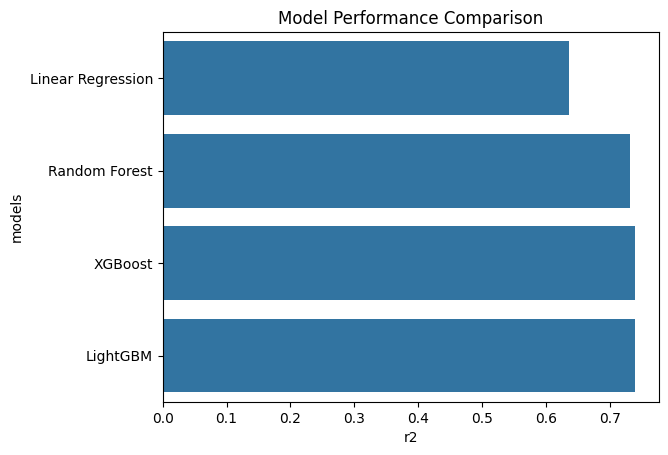

In [32]:
sns.barplot(results_df1, y = 'models', x = 'r2')
plt.title('Model Performance Comparison')
plt.show()

Linear Regression has the lowest predictive performance, indicating it cannot capture non-linear relationships in the data.

Random Forest improves performance significantly compared to the linear regression model, capturing non-linear patterns and interactions.

XGBoost model performs slightly better than Random Forest, showing marginal gains from gradient boosting.

LightGBM gives the best R², yet not much different from thr random forest and XGBoost models.